# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from lightgbm import LGBMRegressor
from scikeras.wrappers import KerasRegressor
import joblib
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Read data

In [2]:
# Cargar los dataset para el en analisis exploratorio y la experimentacion de modelos
catalogo_productos = pd.read_csv('Datos/catalogo_productos.csv', sep=',', encoding='utf-8')
demanda = pd.read_csv('Datos/demanda.csv', sep=',', encoding='utf-8')

# Analisis exploratorio de datos (EDA)

## Análisis exploratorio

### Revision de tamaños del dataset

In [3]:
# Visualizar las primeras filas para revisar la estructura de los datos
print("Tamaño del dataset de catalogo:", catalogo_productos.shape)
print("Productos unicos en catalogo:", catalogo_productos["id_producto"].nunique())

print("Tamaño del dataset de demanda:", demanda.shape)
print("Productos unicos en demanda:", demanda["id_producto"].nunique())

Tamaño del dataset de catalogo: (135, 8)
Productos unicos en catalogo: 135
Tamaño del dataset de demanda: (126460, 3)
Productos unicos en demanda: 135


In [4]:
# Se combinan los datos de demanda con el catálogo de productos
demanda_completa = pd.merge(demanda, catalogo_productos, on='id_producto', how='inner')

# Se muestra el tamaño del dataset combinado para verificar el resultado de la combinación
print("Tamaño del dataset de demanda_completa:", demanda_completa.shape)
print("Productos únicos en demanda_completa:", demanda_completa["id_producto"].nunique())

demanda_completa.head()

Tamaño del dataset de demanda_completa: (126460, 10)
Productos únicos en demanda_completa: 135


,date,id_producto,demanda,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,nit_proveedor
0,2020-01-01,3,869,bebidas,Gaseosa,Pequeño,0.0,1,0,890900667.0
1,2020-01-01,4,407,congelados,Vegetales,Pequeño,0.0,1,1,890900667.0
2,2020-01-01,5,182,shampoos,Acondicionador,Pequeño,0.0,1,0,890900667.0
3,2020-01-01,6,91,bebidas,Cerveza Internacional,Pequeño,0.0,0,0,890900667.0
4,2020-01-01,7,520,panaderia_y_panificados,Otros,Pequeño,0.0,1,0,890900667.0


In [5]:
# Convertir la columna de fecha a datetime
demanda_completa['date'] = pd.to_datetime(demanda_completa['date'])

# Extraer día, mes, año y día de la semana para usarlo como variable dentro de los modelos
demanda_completa['dia'] = demanda_completa['date'].dt.day
demanda_completa['mes'] = demanda_completa['date'].dt.month
demanda_completa['año'] = demanda_completa['date'].dt.year
demanda_completa['dia_semana'] = demanda_completa['date'].dt.dayofweek 

# Crear columna booelana llamada Competencia: True si fecha es >= '2021-07-02'
demanda_completa['Competencia'] = demanda_completa['date'] >= pd.Timestamp('2021-07-02')

### Revision y tratamiento de valores nulos

In [6]:
# Calcular el porcentaje de valores nulos
null_percentage = (demanda_completa.isnull().sum() / len(demanda_completa)) * 100
print("Porcentaje de Valores Nulos por Columna:")
print(null_percentage)

Porcentaje de Valores Nulos por Columna:
date                0.000000
id_producto         0.000000
demanda             0.000000
categoria           0.000000
subcategoria       23.748221
tamaño              1.772102
premium             3.382097
marca_exclusiva     0.000000
estacional          0.000000
nit_proveedor       0.812905
dia                 0.000000
mes                 0.000000
año                 0.000000
dia_semana          0.000000
Competencia         0.000000
dtype: float64


In [7]:
demanda_completa["tamaño"].value_counts(), demanda_completa["premium"].value_counts()

(tamaño
 Pequeño    98435
 Mediano    19484
 Grande      6300
 Name: count, dtype: int64,
 premium
 0.0    112055
 1.0     10128
 Name: count, dtype: int64)

In [ ]:
demanda_completa_sin_nulos = demanda_completa.copy()

# En las columnas 'tamaño' y 'premium', los valores nulos se reemplazan con la moda ya que el porcentaje de nulos no es muy grande y la moda equivale a casi el 80% del dataset en ambos casos


# Imputar los valores nulos de la columna 'tamaño' con la moda ya los valores nulos no son tan grandes
print("Los valores nulos de tamaño se reemplazan por la moda:", demanda_completa_sin_nulos['tamaño'].mode()[0])
demanda_completa_sin_nulos['tamaño'].fillna(demanda_completa_sin_nulos['tamaño'].mode()[0], inplace=True)

# Imputar los valores nulos de la columna 'premium' con la moda ya los valores nulos no son tan grandes
print("Los valores nulos de premium se reemplazan por la moda:", demanda_completa_sin_nulos['premium'].mode()[0])
demanda_completa_sin_nulos['premium'].fillna(demanda_completa_sin_nulos['premium'].mode()[0], inplace=True)


# Eliminar la columna 'nit_proveedor' ya que no aporta variabilidad al modelo (solo un valor único)
demanda_completa_sin_nulos = demanda_completa_sin_nulos.drop(columns=['nit_proveedor'])

# Verificar los valores nulos después de la imputación
vlores_demanda_completa_sin_nulos = demanda_completa_sin_nulos.isnull().sum()
print("demanda_completa_sin_nulos")
print(vlores_demanda_completa_sin_nulos)

Los valores nulos de tamaño se reemplazan por la moda: Pequeño
Los valores nulos de premium se reemplazan por la moda: 0.0
demanda_completa_sin_nulos
date                   0
id_producto            0
demanda                0
categoria              0
subcategoria       30032
tamaño                 0
premium                0
marca_exclusiva        0
estacional             0
dia                    0
mes                    0
año                    0
dia_semana             0
Competencia            0
dtype: int64


/var/folders/83/lhxwld796l7cx3lyt07ml50m0000gn/T/ipykernel_5500/660378713.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  demanda_completa_sin_nulos['tamaño'].fillna(demanda_completa_sin_nulos['tamaño'].mode()[0], inplace=True)
/var/folders/83/lhxwld796l7cx3lyt07ml50m0000gn/T/ipykernel_5500/660378713.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

In [33]:
moda_subcategoria_por_categoria = demanda_completa.groupby('categoria')['subcategoria'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Calcular el porcentaje que representa la moda de cada subcategoría respecto al total de su categoría
porcentaje_moda_por_categoria = {}

# Iterar sobre cada categoría y calcular el porcentaje de la moda
for categoria, subcategoria_moda in moda_subcategoria_por_categoria.items():
    total_categoria = demanda_completa[demanda_completa['categoria'] == categoria].shape[0]
    moda_count = demanda_completa[(demanda_completa['categoria'] == categoria) & 
                                  (demanda_completa['subcategoria'] == subcategoria_moda)].shape[0]
    porcentaje_moda_por_categoria[categoria] = (moda_count / total_categoria) * 100

# Mostrar el porcentaje que representa la moda en cada categoría
for categoria, porcentaje in porcentaje_moda_por_categoria.items():
    print(f"Categoría: {categoria} - Moda representa el {porcentaje:.2f}% de la categoría")


Categoría: aseo - Moda representa el 59.96% de la categoría
Categoría: bebidas - Moda representa el 23.38% de la categoría
Categoría: carnes_y_aves - Moda representa el 38.07% de la categoría
Categoría: cereales_y_productos_secos - Moda representa el 33.99% de la categoría
Categoría: congelados - Moda representa el 40.91% de la categoría
Categoría: frutas_y_verduras - Moda representa el 49.93% de la categoría
Categoría: jabones - Moda representa el 100.00% de la categoría
Categoría: panaderia_y_panificados - Moda representa el 33.50% de la categoría
Categoría: productos_enlatados_y_alimentos_envasados - Moda representa el 0.00% de la categoría
Categoría: productos_lacteos - Moda representa el 34.85% de la categoría
Categoría: shampoos - Moda representa el 55.68% de la categoría


In [ ]:
# Definir los umbrales de decisión para imputar con la moda o no en la columna subcategoria
umbrales = {
    'alto': 50,  # Porcentaje alto de representatividad para imputación directa
    'moderado': 30  # Porcentaje moderado para considerar la imputación con precaución
}

# Imputar valores nulos sólo en categorías con moda representativa
for categoria, porcentaje in porcentaje_moda_por_categoria.items():
    if porcentaje >= umbrales['alto']:

        # Imputación directa con la moda en categorías con representatividad alta
        moda = moda_subcategoria_por_categoria[categoria]
        demanda_completa_sin_nulos.loc[(demanda_completa_sin_nulos['categoria'] == categoria) & (demanda_completa_sin_nulos['subcategoria'].isnull()), 'subcategoria'] = moda

    elif umbrales['moderado'] <= porcentaje < umbrales['alto']:

        # Imputación con precaución en categorías con representatividad moderada
        moda = moda_subcategoria_por_categoria[categoria]
        demanda_completa_sin_nulos.loc[(demanda_completa_sin_nulos['categoria'] == categoria) & (demanda_completa_sin_nulos['subcategoria'].isnull()), 'subcategoria'] = moda

    else:

        # Imputar con 'Otros' si el porcentaje es bajo (Valor existente ya en el dataset)
        demanda_completa_sin_nulos.loc[(demanda_completa_sin_nulos['categoria'] == categoria) & (demanda_completa_sin_nulos['subcategoria'].isnull()), 'subcategoria'] = "Otros"


# Verificar la cantidad de valores nulos en 'subcategoria' después de la imputación selectiva
valores_nulos_subcategoria_post_imputacion = demanda_completa_sin_nulos['subcategoria'].isnull().sum()
print("Valores nulos en 'subcategoria' después de la imputación:", valores_nulos_subcategoria_post_imputacion)

Valores nulos en 'subcategoria' después de la imputación: 0


In [35]:
demanda_completa_sin_nulos.head()

,date,id_producto,demanda,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,dia,mes,año,dia_semana,Competencia
0,2020-01-01,3,869,bebidas,Gaseosa,Pequeño,0.0,1,0,1,1,2020,2,False
1,2020-01-01,4,407,congelados,Vegetales,Pequeño,0.0,1,1,1,1,2020,2,False
2,2020-01-01,5,182,shampoos,Acondicionador,Pequeño,0.0,1,0,1,1,2020,2,False
3,2020-01-01,6,91,bebidas,Cerveza Internacional,Pequeño,0.0,0,0,1,1,2020,2,False
4,2020-01-01,7,520,panaderia_y_panificados,Otros,Pequeño,0.0,1,0,1,1,2020,2,False


### Distribucion de valores

Media de demanda: 318.92593705519533
Mediana de demanda: 290.0
Moda de demanda: 196
Desviación estándar de demanda: 196.34563648513236


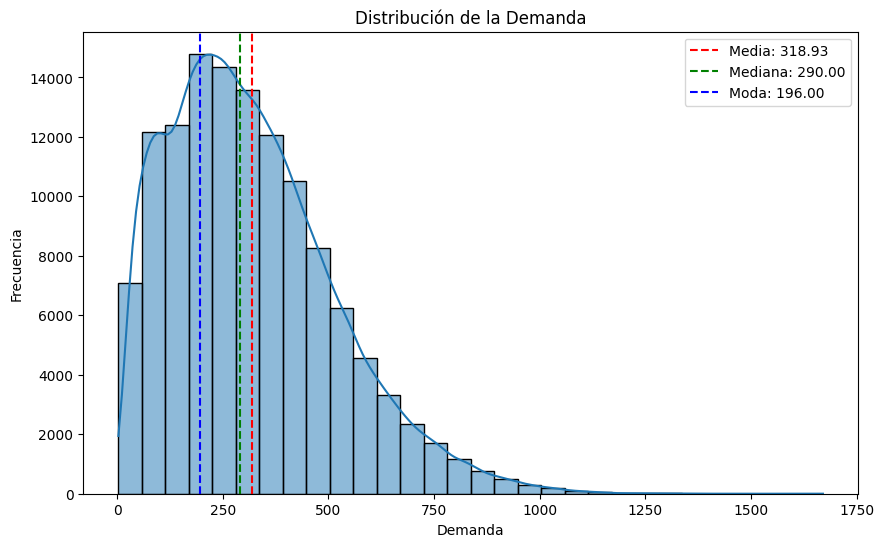

In [ ]:
# Revision de estadísticas descriptivas
media_demanda = demanda_completa_sin_nulos['demanda'].mean()
mediana_demanda = demanda_completa_sin_nulos['demanda'].median()
moda_demanda = demanda_completa_sin_nulos['demanda'].mode()[0]
std_demanda = demanda_completa_sin_nulos['demanda'].std()

# Visualizar distribución de demanda
plt.figure(figsize=(10, 6))
sns.histplot(demanda_completa_sin_nulos['demanda'], kde=True, bins=30)
plt.axvline(media_demanda, color='r', linestyle='--', label=f'Media: {media_demanda:.2f}')
plt.axvline(mediana_demanda, color='g', linestyle='--', label=f'Mediana: {mediana_demanda:.2f}')
plt.axvline(moda_demanda, color='b', linestyle='--', label=f'Moda: {moda_demanda:.2f}')
plt.title('Distribución de la Demanda')
plt.xlabel('Demanda')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

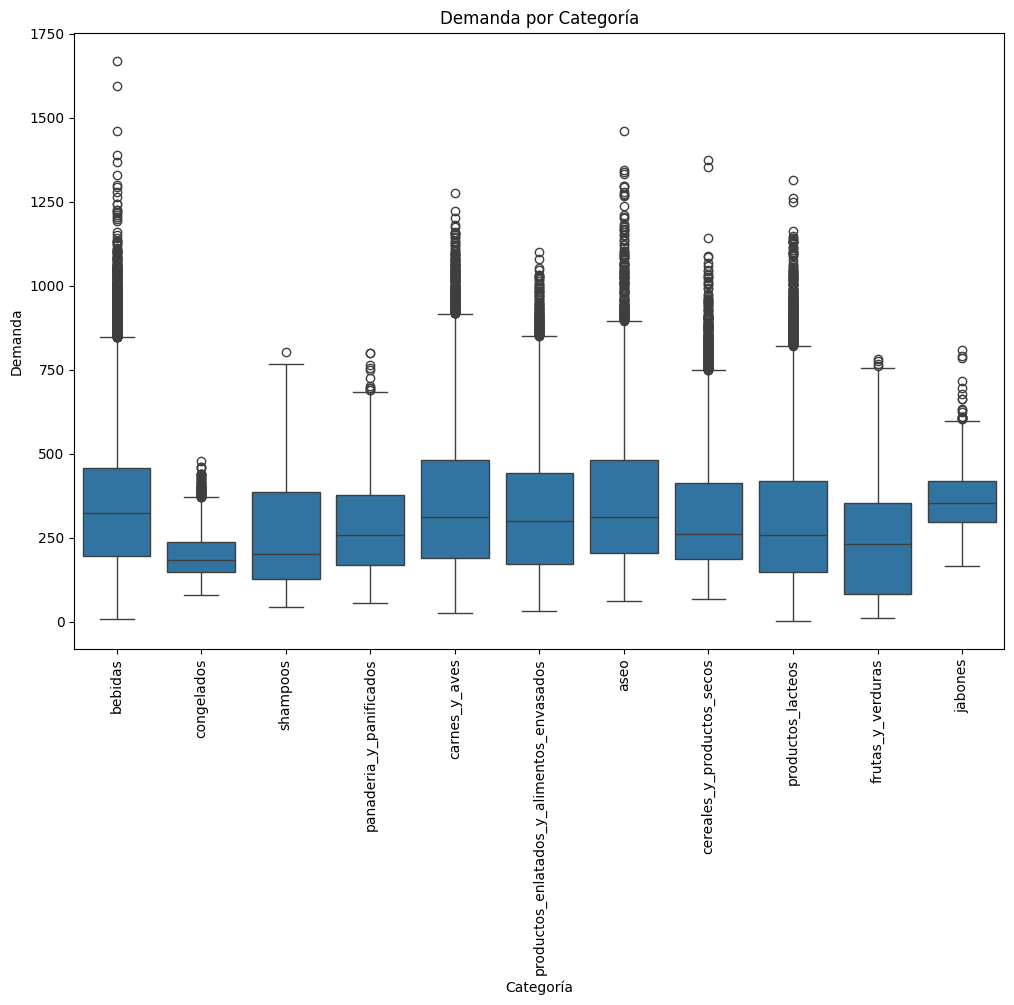

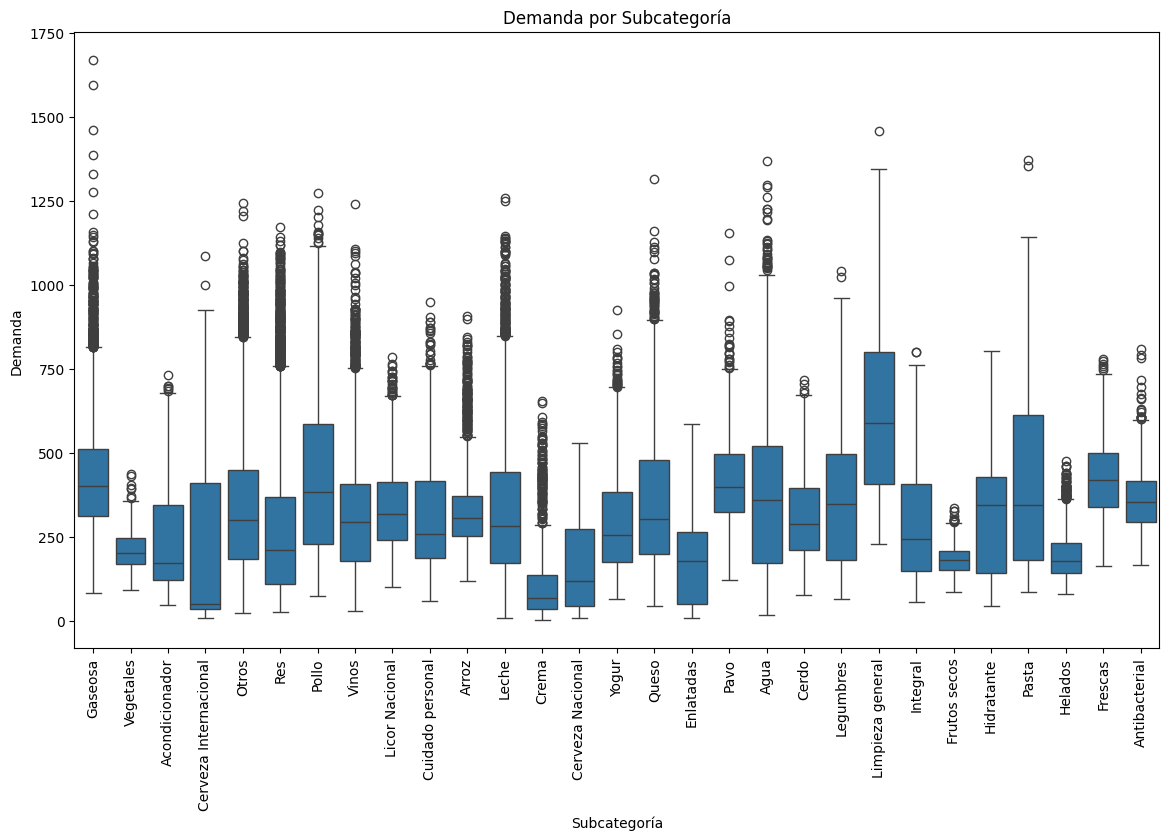

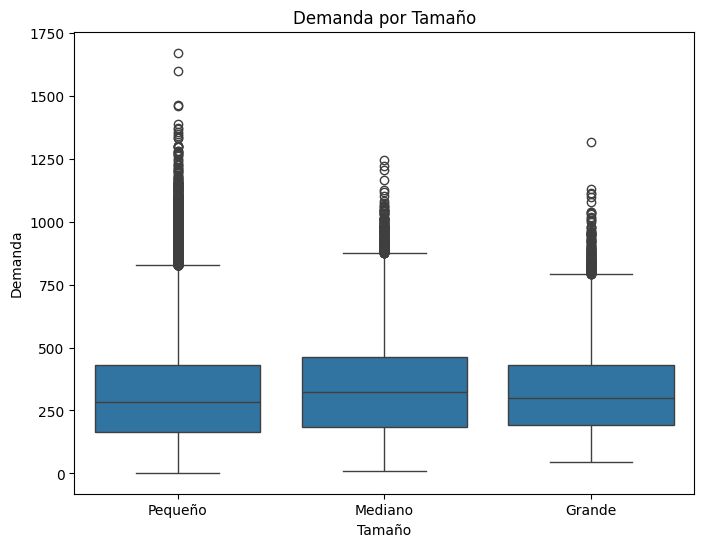

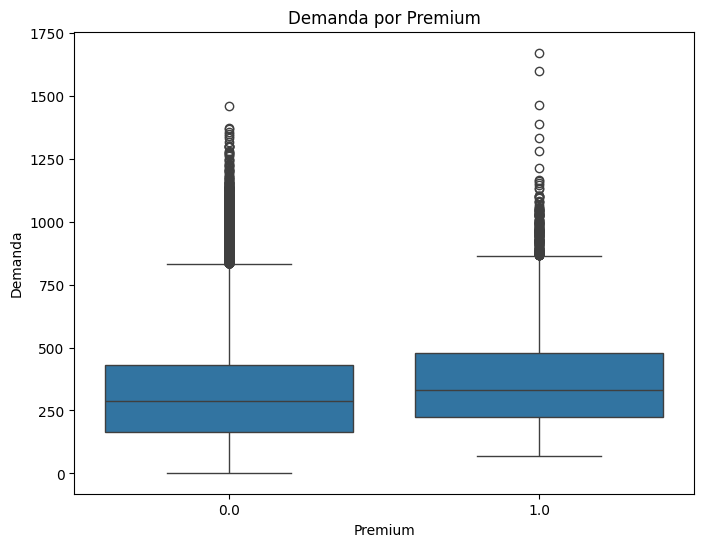

In [ ]:
# Boxplot de Demanda por Categoría para revisar si hay algún patron que nos ayude a determinar si la columna da valor o no

plt.figure(figsize=(12, 8))
sns.boxplot(data=demanda_completa_sin_nulos, x='categoria', y='demanda')
plt.xticks(rotation=90)
plt.title('Demanda por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Demanda')
plt.show()

# Boxplot de Demanda por Subcategoría para revisar si hay algún patron que nos ayude a determinar si la columna da valor o no
plt.figure(figsize=(14, 8))
sns.boxplot(data=demanda_completa_sin_nulos, x='subcategoria', y='demanda')
plt.xticks(rotation=90)
plt.title('Demanda por Subcategoría')
plt.xlabel('Subcategoría')
plt.ylabel('Demanda')
plt.show()

# Boxplot de Demanda por Tamaño para revisar si hay algún patron que nos ayude a determinar si la columna da valor o no
plt.figure(figsize=(8, 6))
sns.boxplot(data=demanda_completa_sin_nulos, x='tamaño', y='demanda')
plt.title('Demanda por Tamaño')
plt.xlabel('Tamaño')
plt.ylabel('Demanda')
plt.show()

# Boxplot de Demanda por Premium para revisar si hay algún patron que nos ayude a determinar si la columna da valor o no
plt.figure(figsize=(8, 6))
sns.boxplot(data=demanda_completa_sin_nulos, x='premium', y='demanda')
plt.title('Demanda por Premium')
plt.xlabel('Premium')
plt.ylabel('Demanda')
plt.show()

### Preguntas

#### ¿Cuál es la estacionalidad de las ventas?, ¿la estacionalidad cambia dependiendo del producto?

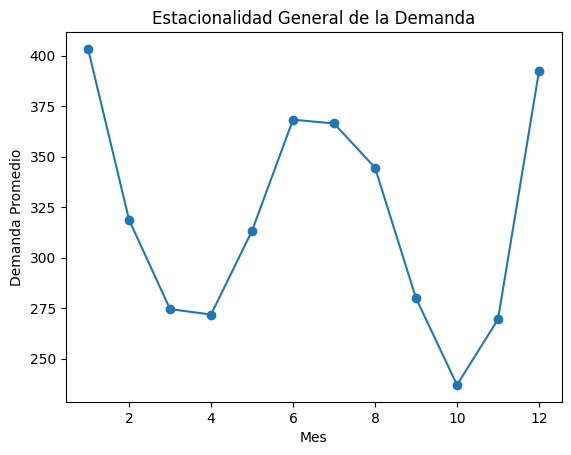

In [ ]:
# Agrupar por mes y calcular la demanda promedio
demanda_mensual = demanda_completa_sin_nulos.groupby('mes')['demanda'].mean()

# Graficar la demanda promedio por mes
demanda_mensual.plot(kind='line', marker='o', title='Estacionalidad General de la Demanda')
plt.xlabel('Mes')
plt.ylabel('Demanda Promedio')
plt.show()

<Figure size 1500x1000 with 0 Axes>

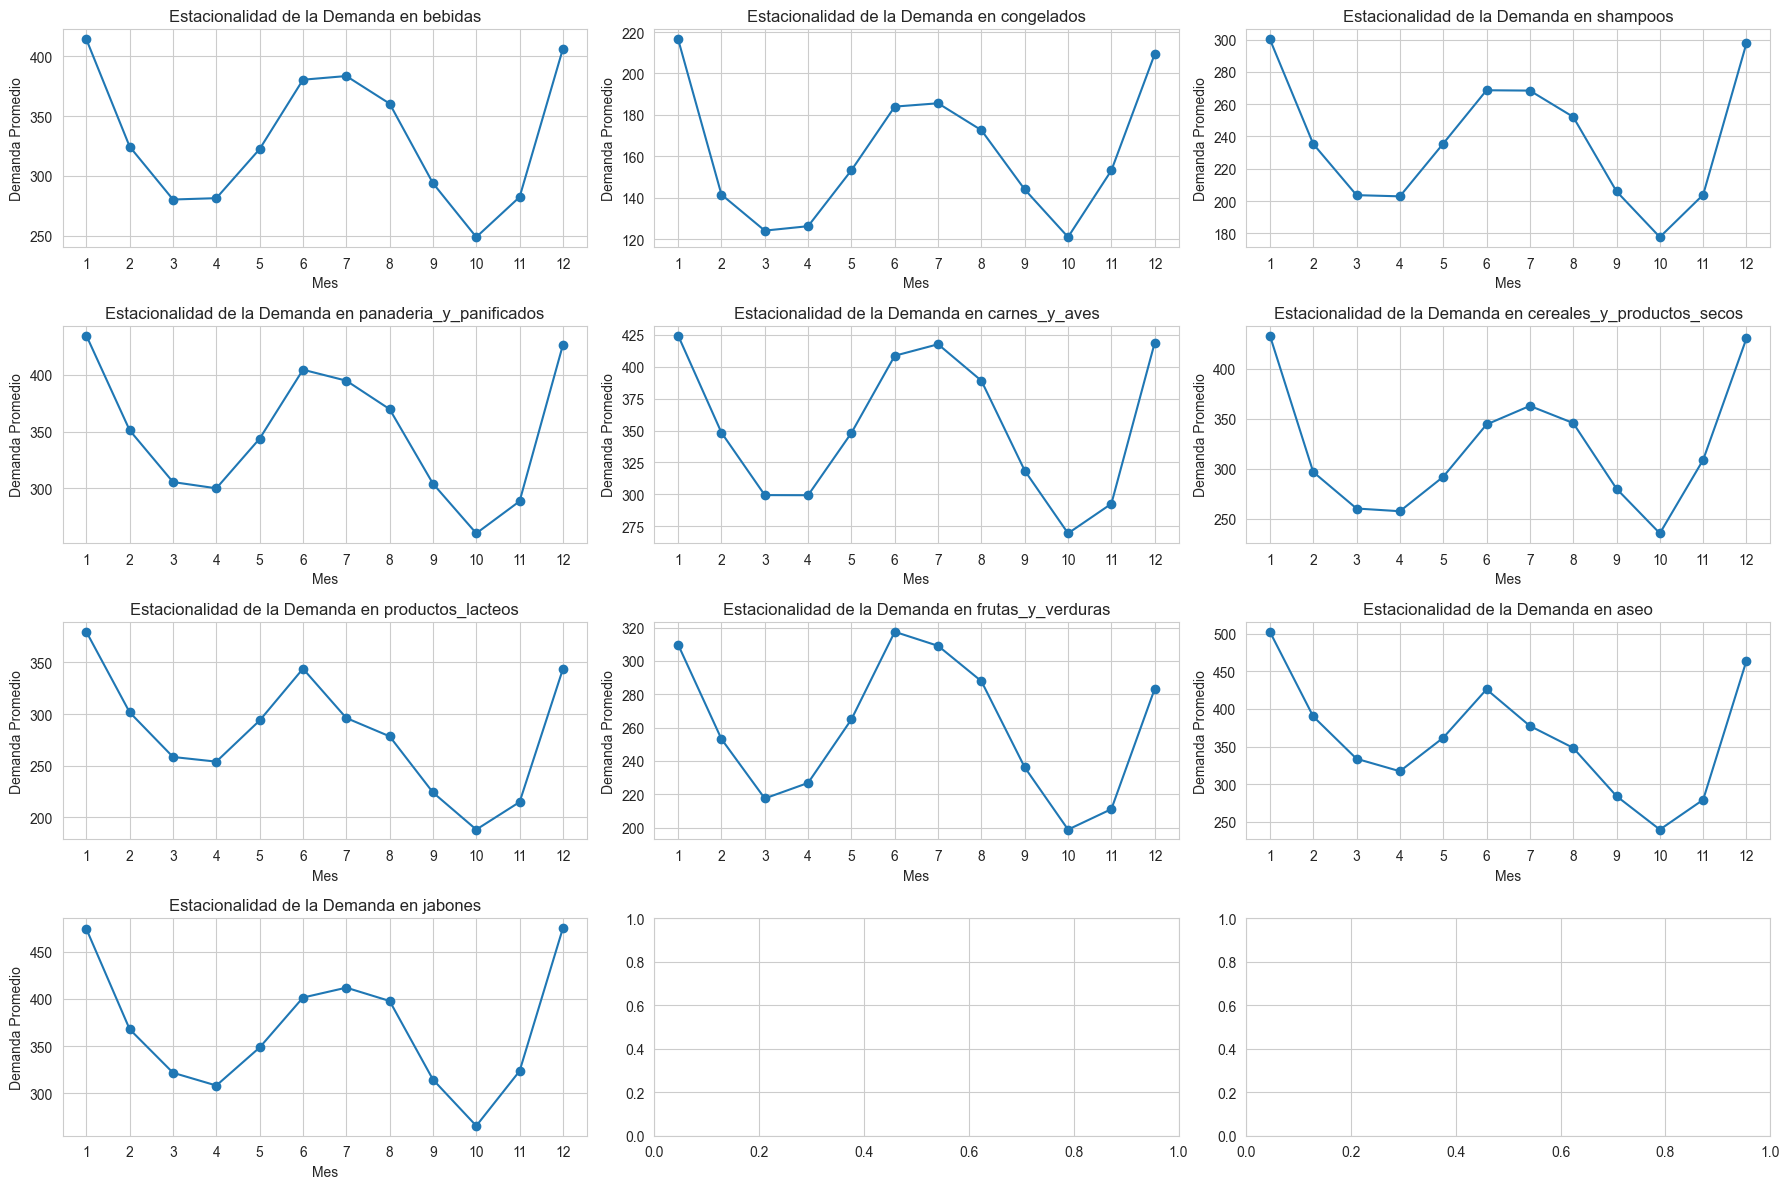

In [54]:
# Configurar el tamaño de las gráficas y el estilo
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Obtener las categorías únicas
categorias = demanda_completa_sin_nulos['categoria'].unique()

# Crear subplots para cada categoría
fig, axes = plt.subplots(nrows=len(categorias)//3 + 1, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Iterar sobre cada categoría y generar la gráfica de estacionalidad
for i, categoria in enumerate(categorias):
    # Filtrar la data por categoría y calcular la demanda promedio por mes
    demanda_por_mes = demanda_completa_sin_nulos[demanda_completa_sin_nulos['categoria'] == categoria].groupby('mes')['demanda'].mean()
    
    # Graficar la demanda promedio mensual para la categoría actual
    axes[i].plot(demanda_por_mes.index, demanda_por_mes.values, marker='o')
    axes[i].set_title(f'Estacionalidad de la Demanda en {categoria}')
    axes[i].set_xlabel('Mes')
    axes[i].set_ylabel('Demanda Promedio')
    axes[i].set_xticks(range(1, 13))

# Ajustar el layout y mostrar las gráficas
plt.tight_layout()
plt.show()

La estacionalidad en la demanda de productos es claramente visible en el análisis general y por categoría. Observamos picos en la demanda en los meses de enero y diciembre, lo cual probablemente está relacionado con festividades importantes, donde el consumo de ciertos productos tiende a aumentar. Este patrón estacional general sugiere que las celebraciones de inicio y fin de año son momentos clave en los que la demanda de diversos productos se incrementa.

A lo largo del año, entre estos dos picos (enero y diciembre), la demanda cae significativamente en los meses intermedios, con niveles particularmente bajos antes y despues de la temporada de verano. Sin embargo, algunas categorías muestran patrones de estacionalidad adicionales. Por ejemplo, en frutas_y_verduras y carnes_y_aves, se observa un tercer pico en la demanda durante el verano, alcanzando niveles similares a los de las festividades de inicio y fin de año. Esto podría estar relacionado con el hecho de que, durante las vacaciones de verano, las personas pasan más tiempo en casa y consumen más de estos productos frescos.

#### ¿Cúal fué el impacto de la apertura del competidor?

In [33]:

# Comparación general antes y después de la apertura
demanda_antes = demanda_completa_sin_nulos[demanda_completa_sin_nulos['Competencia'] == False]['demanda'].mean()
demanda_despues = demanda_completa_sin_nulos[demanda_completa_sin_nulos['Competencia'] == True]['demanda'].mean()
print("Demanda promedio antes de la apertura:", demanda_antes)
print("Demanda promedio después de la apertura:", demanda_despues)

# Comparación por categoría
for categoria in demanda_completa_sin_nulos['categoria'].unique():
    demanda_categoria = demanda_completa_sin_nulos[demanda_completa_sin_nulos['categoria'] == categoria]
    demanda_antes_cat = demanda_categoria[demanda_categoria['Competencia'] == False]['demanda'].mean()
    demanda_despues_cat = demanda_categoria[demanda_categoria['Competencia'] == True]['demanda'].mean()
    print(f"{categoria} - Demanda antes: {demanda_antes_cat}, Demanda después: {demanda_despues_cat}")

Demanda promedio antes de la apertura: 352.9688119953864
Demanda promedio después de la apertura: 282.89374135264916
bebidas - Demanda antes: 365.9798701652938, Demanda después: 306.8531334992188
congelados - Demanda antes: 221.81767515923568, Demanda después: 174.19208573784007
shampoos - Demanda antes: 281.31860862142554, Demanda después: 238.12788592123133
panaderia_y_panificados - Demanda antes: 311.98080614203457, Demanda después: 249.6632860040568
carnes_y_aves - Demanda antes: 377.0923540411386, Demanda después: 326.64575077058566
productos_enlatados_y_alimentos_envasados - Demanda antes: 318.7146394894752, Demanda después: 320.6360982484397
aseo - Demanda antes: 486.64310544611817, Demanda después: 244.36400322841
cereales_y_productos_secos - Demanda antes: 321.1267605633803, Demanda después: 321.0828466363833
productos_lacteos - Demanda antes: 399.16328577797594, Demanda después: 191.48043966434227
frutas_y_verduras - Demanda antes: 274.18615751789974, Demanda después: 208.754

In [ ]:
demanda_completa_sin_nulos.describe()

,date,id_producto,demanda,premium,marca_exclusiva,estacional,dia,mes,año,dia_semana
count,126460,126460.000000,126460.000000,126460.000000,126460.000000,126460.000000,126460.000000,126460.000000,126460.000000,126460.000000
mean,2021-06-15 21:19:40.262533120,67.973992,318.925937,0.080089,0.552024,0.023834,15.724071,6.392195,2020.967136,2.999494
min,2020-01-01 00:00:00,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2020.000000,0.000000
25%,2020-09-26 00:00:00,34.000000,169.000000,0.000000,0.000000,0.000000,8.000000,3.000000,2020.000000,1.000000
50%,2021-06-16 00:00:00,68.000000,290.000000,0.000000,1.000000,0.000000,16.000000,6.000000,2021.000000,3.000000
75%,2022-03-06 00:00:00,102.000000,435.000000,0.000000,1.000000,0.000000,23.000000,9.000000,2022.000000,5.000000
max,2022-11-30 00:00:00,135.000000,1670.000000,1.000000,1.000000,1.000000,31.000000,12.000000,2022.000000,6.000000
std,NaN,39.130271,196.345636,0.271431,0.497288,0.152531,8.798788,3.423028,0.809676,1.998885


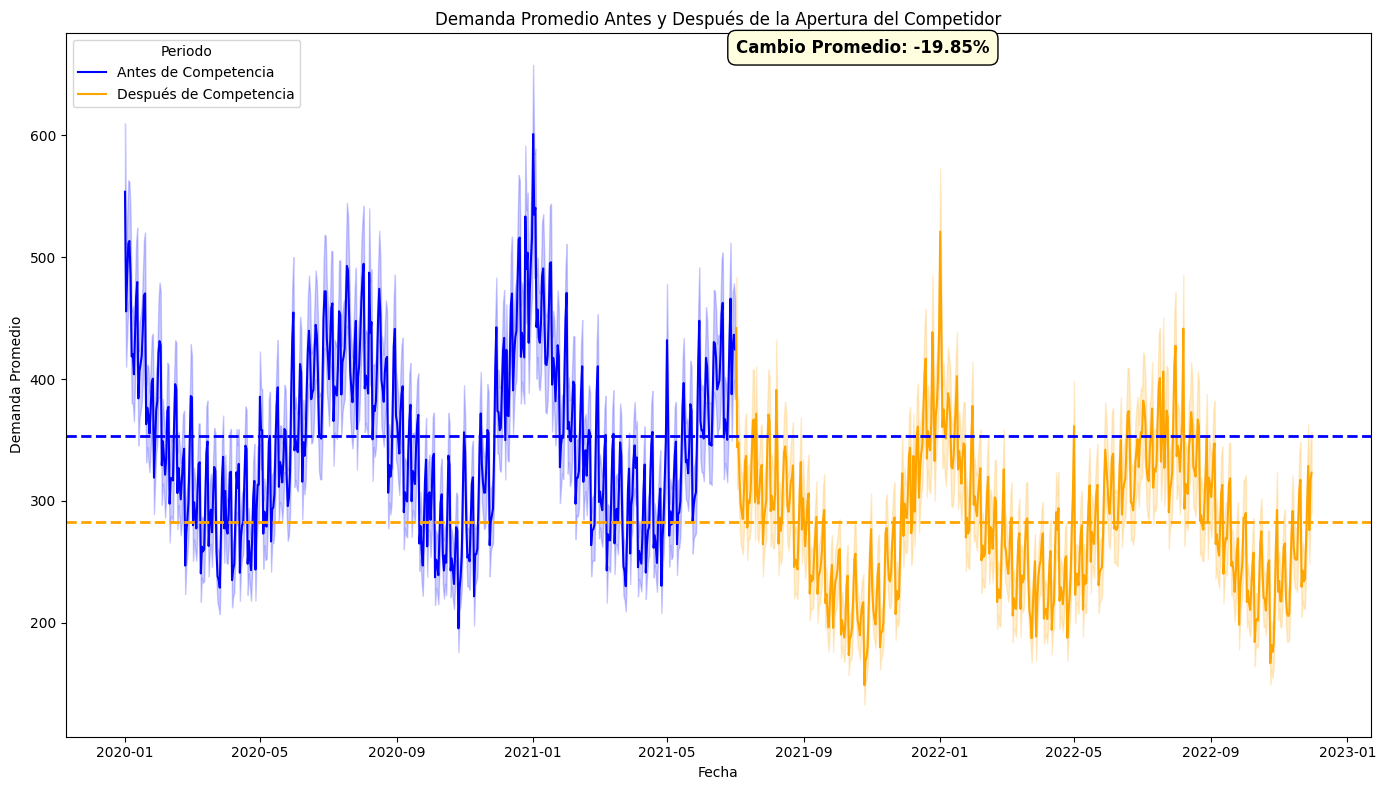

In [ ]:
# Calcular las medias antes y después de la apertura
media_antes = demanda_completa_sin_nulos[demanda_completa_sin_nulos['Competencia'] == False]['demanda'].mean()
media_despues = demanda_completa_sin_nulos[demanda_completa_sin_nulos['Competencia'] == True]['demanda'].mean()

# Calcular el cambio porcentual
cambio_porcentual = ((media_despues - media_antes) / media_antes) * 100

# Obtener la fecha de apertura del competidor
fecha_apertura = demanda_completa_sin_nulos[demanda_completa_sin_nulos['Competencia'] == True]['date'].min()

# Crear la gráfica
plt.figure(figsize=(14, 8))

# Cambiar los nombres en la leyenda para que sean más descriptivos
sns.lineplot(data=demanda_completa_sin_nulos, x='date', y='demanda', 
             hue='Competencia', 
             palette=['blue', 'orange'], 
             hue_order=[False, True],
             legend='full').set(title='Demanda Promedio Antes y Después de la Apertura del Competidor')

# Actualizar las etiquetas de la leyenda manualmente
leg = plt.legend(loc='upper left', title='Periodo')
new_labels = ['Antes de Competencia', 'Después de Competencia', 
              f'Media Antes de Apertura: {media_antes:.2f}', 
              f'Media Después de Apertura: {media_despues:.2f}']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

# Añadir las líneas de la media antes y después
plt.axhline(media_antes, color='blue', linestyle='--', linewidth=2)
plt.axhline(media_despues, color='orange', linestyle='--', linewidth=2)

# Añadir el cambio porcentual en una caja de texto
texto_cambio = f"Cambio Promedio: {cambio_porcentual:.2f}%"
plt.text(fecha_apertura, max(demanda_completa_sin_nulos['demanda']) * 0.4, texto_cambio, 
         color="black", fontsize=12, fontweight="bold",
         bbox=dict(facecolor="lightyellow", edgecolor="black", boxstyle="round,pad=0.5"))

# Etiquetas adicionales
plt.xlabel('Fecha')
plt.ylabel('Demanda Promedio')

# Ajustar el espaciado para reducir los márgenes en blanco
plt.tight_layout()
plt.show()

Como se puede observar en la gráfica superior y en la Demanda promedio por categoria, 
todos los productos a excepcion de los productos Enlatados y Alimentos Envasados, tuvieron una reducción
en la demanda despues del 2 de julio de 2021, fecha en la que entró en operación una tienda de la competencia a pocos metros

Se puede conncluir que desde que la competencia entró en operación, la demanda ha sido mucho menor casi todos los productos. Esta reducción
de demanda se observa en la gráfica superior, en la que la demanda promedio antes de la apertura de la tienda era de 352.97, mientras que
la demanda promedio despues de la apertura de la tienda es de 282.89, una reduccion del 19.85%

#### ¿Las ventas tienen una tendencia creciente o decreciente?

Pendiente antes de la apertura del competidor: -0.007388990279213287
Pendiente después de la apertura del competidor: -0.010263326655285846
Pendiente general de la demanda: -0.11282881884645575


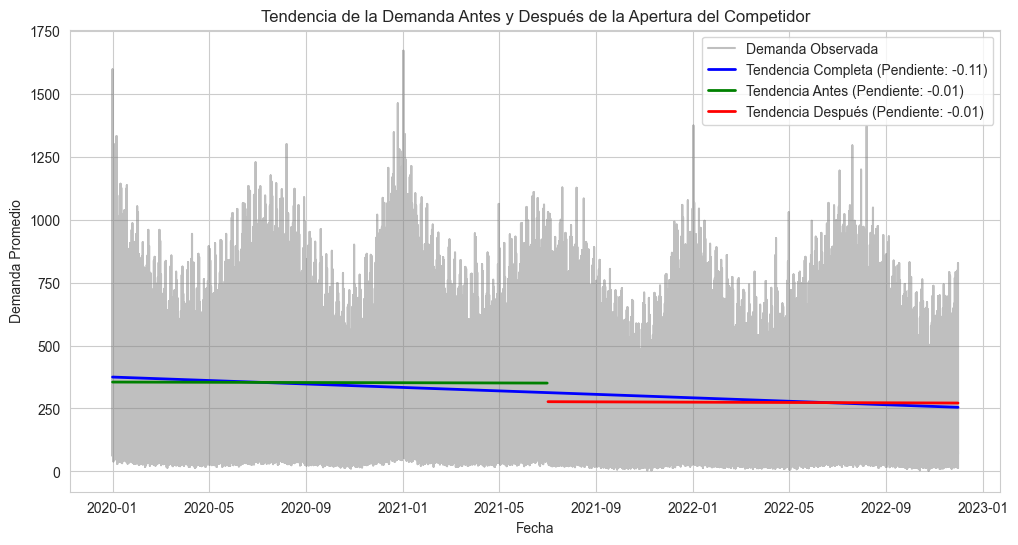

In [56]:
tendencia = demanda_completa_sin_nulos.copy()

# Crear una columna numérica de tiempo para usar en la regresión
tendencia['time_num'] = (tendencia['date'] - tendencia['date'].min()).dt.days

# Dividir los datos en antes y después de la apertura del competidor
datos_antes = tendencia[tendencia['Competencia'] == False]
datos_despues = tendencia[tendencia['Competencia'] == True]

# Regresión lineal para los datos antes de la apertura
X_antes = datos_antes[['time_num']]
y_antes = datos_antes['demanda']
modelo_antes = LinearRegression().fit(X_antes, y_antes)
pendiente_antes = modelo_antes.coef_[0]

# Regresión lineal para los datos después de la apertura
X_despues = datos_despues[['time_num']]
y_despues = datos_despues['demanda']
modelo_despues = LinearRegression().fit(X_despues, y_despues)
pendiente_despues = modelo_despues.coef_[0]

# Regresión lineal para todos los datos (tendencia completa)
X_total = tendencia[['time_num']]
y_total = tendencia['demanda']
modelo_total = LinearRegression().fit(X_total, y_total)
pendiente_total = modelo_total.coef_[0]

# Imprimir las pendientes de cada periodo y la tendencia general
print(f"Pendiente antes de la apertura del competidor: {pendiente_antes}")
print(f"Pendiente después de la apertura del competidor: {pendiente_despues}")
print(f"Pendiente general de la demanda: {pendiente_total}")

# Visualización de la tendencia completa con regresión lineal
plt.figure(figsize=(12, 6))
plt.plot(tendencia['date'], tendencia['demanda'], color='gray', alpha=0.5, label='Demanda Observada')

# Línea de tendencia completa
tendencia_total = modelo_total.predict(X_total)
plt.plot(tendencia['date'], tendencia_total, color='blue', linewidth=2, label=f'Tendencia Completa (Pendiente: {pendiente_total:.2f})')

# Línea de tendencia antes de la apertura
tendencia_antes = modelo_antes.predict(X_antes)
plt.plot(datos_antes['date'], tendencia_antes, color='green', linewidth=2, label=f'Tendencia Antes (Pendiente: {pendiente_antes:.2f})')

# Línea de tendencia después de la apertura
tendencia_despues = modelo_despues.predict(X_despues)
plt.plot(datos_despues['date'], tendencia_despues, color='red', linewidth=2, label=f'Tendencia Después (Pendiente: {pendiente_despues:.2f})')

# Etiquetas y leyenda
plt.title('Tendencia de la Demanda Antes y Después de la Apertura del Competidor')
plt.xlabel('Fecha')
plt.ylabel('Demanda Promedio')
plt.legend()
plt.grid(True)
plt.show()

1.	Antes de la apertura del competidor: Existe una ligera tendencia decreciente en la demanda, reflejada por una pendiente negativa pequeña (-0.01). Esto indica que la demanda ya mostraba una leve disminución con el tiempo, incluso antes de la entrada de la competencia.
2.	Después de la apertura del competidor: La pendiente negativa es algo mayor (-0.01), lo que sugiere que la tendencia decreciente sigue igual tras la apertura del competidor. Esta diferencia sugiere que la competencia podría haber tenido un impacto adicional en la reducción de la demanda.


# Modelamiento

### Preprocesamiento

#### Variables categoricas y Train-Test split

In [ ]:
# Aplicar one-hot encoding a las columnas categóricas
demanda_encoded = pd.get_dummies(demanda_completa_sin_nulos, columns=['categoria', 'subcategoria', 'tamaño'], drop_first=True)



# Seleccionar variables predictoras y objetivo
X = demanda_encoded.drop(columns=['demanda', 'date'])
y = demanda_encoded['demanda']

# Dividir los datos en train y test en 80/20 por la cantidad de datos con la que se cuenta. Ademas, se añade stratify para mantener la distribucion de id_producto en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['id_producto'])

# Escalar las variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Red Neuronal

### V1 (Entrenamiento rápido sin GridSearch)

Epoch 1/100


/opt/anaconda3/envs/sumz/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3162/3162 ━━━━━━━━━━━━━━━━━━━━ 2s 398us/step - loss: 33090.6484 - val_loss: 10821.0508
Epoch 2/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 12107.3701 - val_loss: 9556.8965
Epoch 3/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - loss: 11059.4434 - val_loss: 8888.2305
Epoch 4/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 10506.9775 - val_loss: 8245.7949
Epoch 5/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 9666.5205 - val_loss: 7654.4727
Epoch 6/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - loss: 9221.4658 - val_loss: 7313.9644
Epoch 7/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 8826.3301 - val_loss: 6943.0776
Epoch 8/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - loss: 8464.8574 - val_loss: 6710.8203
Epoch 9/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 8281.2578 - val_loss: 6527.0366
Epoch 10/100
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 8133.5728 - val_loss: 6446.8291
Epoch 11/100
3162/3162 ━━━━━━━━━━━━━

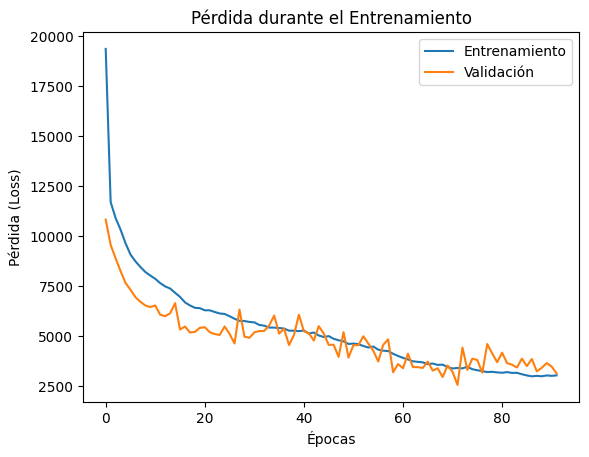

In [ ]:
# Inicializar el modelo
model = Sequential()

# Añadir capas densamente conectadas (fully connected layers)
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Capa de Dropout para reducir el overfitting

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output

# Compilar el modelo con un optimizador adam y lr = 0.001 (default)
model.compile(optimizer='adam', loss='mean_squared_error')

# Configurar Early Stopping para que el entrenamiento no dure tanto en caso que la metrica no mejore con los epochs
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Realizar predicciones en el conjunto de prueba
y_pred_nn = model.predict(X_test_scaled).flatten()

# Calcular el error RMSE en test
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("RMSE del modelo de Red Neuronal:", rmse_nn)


# Gráfica de loss del entrenamiento y validación
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.show()

### V2 (Mas epochs ya que hay underfitting porque se nota que el modelo quizá pueda seguir aprendiendo)

Epoch 1/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 2s 398us/step - loss: 42037.2500 - val_loss: 13321.6865
Epoch 2/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - loss: 13920.6094 - val_loss: 10462.1709
Epoch 3/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step - loss: 11811.4023 - val_loss: 9768.1416
Epoch 4/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - loss: 11300.6660 - val_loss: 9416.8145
Epoch 5/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 10836.8506 - val_loss: 9048.9648
Epoch 6/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 10413.4922 - val_loss: 8558.2021
Epoch 7/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 10158.3447 - val_loss: 8257.7188
Epoch 8/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 9705.2754 - val_loss: 7879.7021
Epoch 9/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 9476.5176 - val_loss: 7479.5142
Epoch 10/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 9112.1836 - val_loss: 7294.2344
Epoch 11/200
3162/31

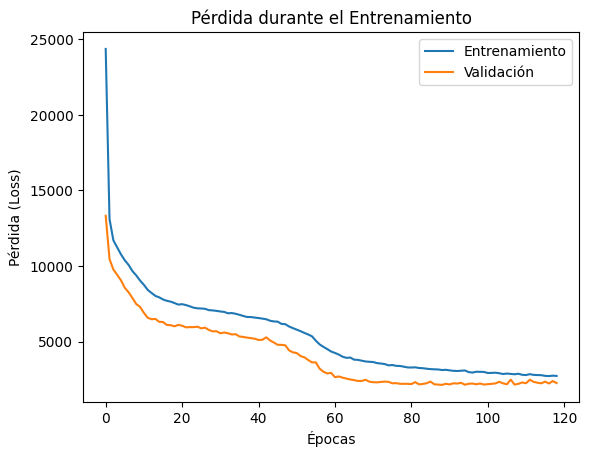

In [ ]:
# Inicializar el modelo
model = Sequential()

# Añadir capas densamente conectadas
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Capa de Dropout para el overfitting

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output

# Compilar el modelo
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Configurar Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Realizar predicciones en el conjunto de prueba
y_pred_nn = model.predict(X_test_scaled).flatten()

# Calcular el error RMSE
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("RMSE del modelo de Red Neuronal:", rmse_nn)


# Gráfica de loss del entrenamiento y validación
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.show()

### V3 (Mas epochs ya que hay un claro underfitting)

Epoch 1/300


/opt/anaconda3/envs/sumz/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3162/3162 ━━━━━━━━━━━━━━━━━━━━ 2s 410us/step - loss: 43375.8516 - val_loss: 13102.8086
Epoch 2/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 13748.3906 - val_loss: 10352.1719
Epoch 3/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - loss: 11766.2549 - val_loss: 9491.2539
Epoch 4/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - loss: 11149.7803 - val_loss: 9110.1729
Epoch 5/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - loss: 10564.6758 - val_loss: 8757.2275
Epoch 6/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - loss: 10483.2461 - val_loss: 8452.7812
Epoch 7/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - loss: 9990.9736 - val_loss: 8160.2275
Epoch 8/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - loss: 9657.9336 - val_loss: 7825.7759
Epoch 9/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - loss: 9457.6123 - val_loss: 7473.8721
Epoch 10/300
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step - loss: 8886.9658 - val_loss: 7054.6343
Epoch 11/300
3162/3162 ━━━━━━━━━━

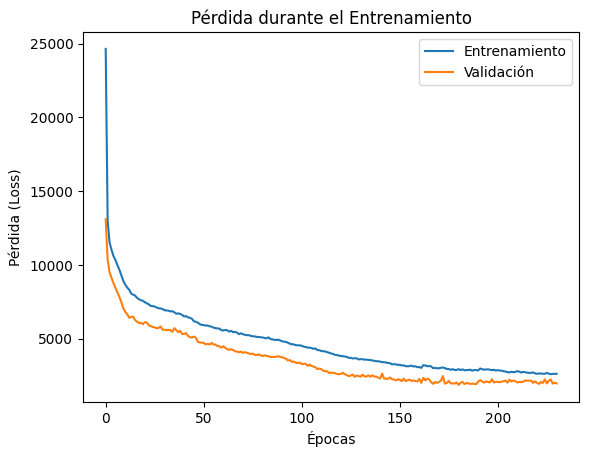

In [ ]:
# Inicializar el modelo
model = Sequential()

# Añadir capas densamente conectadas
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Capa de Dropout para el overfitting

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output

# Compilar el modelo

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Configurar Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=700, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Realizar predicciones en el conjunto de prueba
y_pred_nn = model.predict(X_test_scaled).flatten()

# Calcular el error RMSE
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("RMSE del modelo de Red Neuronal:", rmse_nn)


# Gráfica de loss del entrenamiento y validación
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.show()

### V4 (Modelo base con grid search)

In [ ]:

# Definir una función que crea el modelo
def create_model(learning_rate=0.0005, neurons_1=128, neurons_2=64, neurons_3=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neurons_1, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons_3, activation='relu'))
    model.add(Dense(1))  # Output
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


model = KerasRegressor(build_fn=create_model, verbose=0)

# Definir el param grid de los  hiperparámetros
param_grid = {
    'epochs': [300],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.0001, 0.0005, 0.001],
    'neurons_1': [128, 256],
    'neurons_2': [64, 128],
    'neurons_3': [32, 64],
    'dropout_rate': [0.2, 0.3]
}

# Configurar GridSearchCV con 3 folds
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Realizar gridsearch
grid_result = grid.fit(X_train_scaled, y_train)

# Mejores hiperparámetros
print("Mejores parámetros encontrados: ", grid_result.best_params_)
print("Mejor RMSE encontrado: ", -grid_result.best_score_)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = grid_result.best_params_
final_model = create_model(
    learning_rate=best_params['learning_rate'],
    neurons_1=best_params['neurons_1'],
    neurons_2=best_params['neurons_2'],
    neurons_3=best_params['neurons_3'],
    dropout_rate=best_params['dropout_rate']
)

history = final_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

# Realizar predicciones en el conjunto de test
y_pred_nn = final_model.predict(X_test_scaled).flatten()

# Calcular el RMSE en el conjunto de test
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("RMSE del modelo de Red Neuronal final:", rmse_nn)

# Gráfica de loss del entrenamiento y validación
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.show()

Epoch 1/200


/opt/anaconda3/envs/sumz/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3162/3162 ━━━━━━━━━━━━━━━━━━━━ 2s 412us/step - loss: 33527.7070 - val_loss: 14298.7832
Epoch 2/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step - loss: 15550.7227 - val_loss: 13599.9785
Epoch 3/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - loss: 15058.8818 - val_loss: 13533.7754
Epoch 4/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - loss: 14891.2354 - val_loss: 13830.0342
Epoch 5/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - loss: 14482.7236 - val_loss: 13247.9658
Epoch 6/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - loss: 14323.7510 - val_loss: 13133.7275
Epoch 7/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 14296.9014 - val_loss: 13147.2646
Epoch 8/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 14238.9268 - val_loss: 13035.9434
Epoch 9/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - loss: 14057.9102 - val_loss: 13286.5918
Epoch 10/200
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 14206.6768 - val_loss: 12864.1855
Epoch 11/200
3162/316

## LightGBM

In [ ]:
# Se realiza la codificación one-hot de las columnas categóricas
demanda_completa_sin_nulos_light = pd.get_dummies(demanda_completa_sin_nulos, columns=['categoria', 'subcategoria', 'tamaño'], drop_first=True)

# Seleccionar variables predictoras y objetivo
X = demanda_completa_sin_nulos_light.drop(columns=["demanda", "date" ])
y = demanda_completa_sin_nulos_light["demanda"]

# Se dividen los datos en conjuntos de entrenamiento y prueba. 
# Dividir los datos en train y test en 80/20 por la cantidad de datos con la que se cuenta. Ademas, se añade stratify para mantener la distribucion de id_producto en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['id_producto'])

# Se definen las columnas booleanas (categóricas que requieren codificación).
bool_columns = ["categoria_frutas_y_verduras", "subcategoria_Leche", "subcategoria_Hidratante", "subcategoria_Arroz", 
                "subcategoria_Cerveza Internacional", "subcategoria_Licor Nacional", "categoria_productos_lacteos",
                "categoria_congelados", "subcategoria_Yogur", "subcategoria_Enlatadas", "subcategoria_Cerveza Nacional",
                "categoria_panaderia_y_panificados", "subcategoria_Pavo", "categoria_shampoos", "subcategoria_Queso",
                "subcategoria_Vinos", "subcategoria_Frescas", "categoria_carnes_y_aves", "subcategoria_Limpieza general",
                "marca_exclusiva", "subcategoria_Pollo", "tamaño_Mediano", "premium", "categoria_bebidas", 
                "subcategoria_Gaseosa", "subcategoria_Integral", "subcategoria_Frutos secos", "subcategoria_Otros",
                "tamaño_Pequeño", "categoria_cereales_y_productos_secos", "subcategoria_Legumbres", "subcategoria_Res",
                "subcategoria_Agua", "subcategoria_Cuidado personal", "subcategoria_Cerdo", "subcategoria_Pasta", 
                "Competencia", "subcategoria_Helados", "estacional", "subcategoria_Vegetales", "subcategoria_Crema"]

# Se definen las columnas numéricas.
numerical_columns = ["marca_exclusiva", "premium", "mes", "año" , "estacional", "dia_semana", "dia", "id_producto"]

# Se configura el pipeline para el preprocesamiento de variables booleanas.
bool_pipeline = Pipeline(steps=[
    ("imputers", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

# Se configura el pipeline para el preprocesamiento de variables numéricas.
numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Se configura el preprocesador principal para aplicar ambos pipelines, manteniendo
# el resto de las columnas sin modificar.
preprocessor = ColumnTransformer(
    transformers=[
        ('boolean', bool_pipeline, bool_columns),
        ('numerical', numerical_pipeline, numerical_columns)
    ],
    remainder='passthrough'
)

# Se aplican los preprocesadores a los conjuntos de entrenamiento y prueba.
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Se define una función que crea el modelo LGBMRegressor con parámetros específicos.
def create_model(params):
    return LGBMRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        lambda_l1=params['lambda_l1'],
        lambda_l2=params['lambda_l2'],
        random_state=42
    )

# Se define la función objetivo para la optimización con cross validation (3 splits).
def objective(params):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_list = []

    # Se realiza la validación cruzada con los datos preprocesados.
    for train_idx, val_idx in kf.split(X_train_processed):
        X_tr, X_val = X_train_processed[train_idx], X_train_processed[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = create_model(params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_list.append(rmse)
    
    # Devuelve el error promedio (RMSE) como métrica a minimizar.
    return {'loss': np.mean(rmse_list), 'status': STATUS_OK}

# Se define el paramgrid de hiperparámetros para el modelo.
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 300, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'lambda_l1': hp.uniform('lambda_l1', 0, 1),
    'lambda_l2': hp.uniform('lambda_l2', 0, 1)
}

# Se realiza la optimización de hiperparámetros usando Hyperopt y se guardan los mejores parámetros.
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)

# Se entrena el modelo final con los mejores parámetros obtenidos.
final_model = create_model(best_params)
final_model.fit(X_train_processed, y_train)

# Se realizan las predicciones y se redondean los valores predichos al entero más cercano.
y_pred_final = final_model.predict(X_test_processed)
y_pred_final = np.rint(y_pred_final).astype(int)

# Se calculan y muestran las métricas de rendimiento (RMSE y R²) para el modelo final.
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print("RMSE final del modelo LightGBM:", rmse_final)
print("R² final del modelo LightGBM:", r2_final)

[LightGBM] [Warning] lambda_l1 is set=0.9581253928828153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9581253928828153
[LightGBM] [Warning] lambda_l2 is set=0.9019800138862777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9019800138862777
[LightGBM] [Warning] lambda_l1 is set=0.9581253928828153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9581253928828153
[LightGBM] [Warning] lambda_l2 is set=0.9019800138862777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9019800138862777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 290                      
[LightGBM] [Info] Number of data points in the train set: 67445, number of used features: 52
[LightGBM] [Info] Start training from score 319.797479
[LightGBM] [Warning] No further split

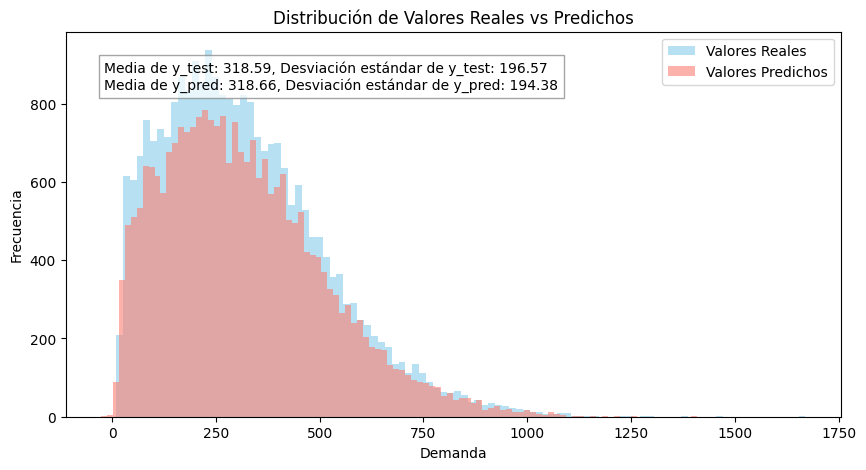

In [ ]:
# Crear la figura del histograma de y vs y_pred para ver la distribucion valores de salida
plt.figure(figsize=(10, 5))
plt.hist(y_test, bins=100, alpha=0.6, label='Valores Reales', color='skyblue')
plt.hist(y_pred_final, bins=100, alpha=0.6, label='Valores Predichos', color='salmon')
plt.xlabel('Demanda')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Reales vs Predichos')
plt.legend()

# Cálculo de la media y desviación estándar de y_test y y_pred
mean_y_test = np.mean(y_test)
std_y_test = np.std(y_test)
mean_y_pred = np.mean(y_pred_final)
std_y_pred = np.std(y_pred_final)

# Añadir el texto con la media y desviación estándar en la gráfica
plt.text(
    0.05, 0.85, 
    f"Media de y_test: {mean_y_test:.2f}, Desviación estándar de y_test: {std_y_test:.2f}\n"
    f"Media de y_pred: {mean_y_pred:.2f}, Desviación estándar de y_pred: {std_y_pred:.2f}", 
    transform=plt.gca().transAxes,
    fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

# Mostrar la gráfica
plt.show()

## Conclusiones

Se observa que el mejor modelo entre la red neuronal y LightGBM, fue LightGBM con un RMSE de 24.31. Para explicar este valor a una persona de negocio, tenemos que tener el contexto del problema y de los datos de entrenamiento. Ya que la media de demanda es aproximadamente 320, un RMSE de 24.31 sigifica que en promedio, el modelo se equivoca en 24 unidades de demanda al hacer predicciones. Lo que significa que en promedio, el error al ahacer predicciones será del 7.5%.

# Guardar modelo para hacer predicciones

In [36]:
# Crear la base de características por producto
caracteristicas_producto = demanda_completa_sin_nulos.groupby('id_producto').agg({
    'categoria': 'first',
    'subcategoria': 'first',
    'tamaño': 'first',
    'premium': 'first',
    'marca_exclusiva': 'first',
    'estacional': 'first'
}).reset_index()

# Renombrar las columnas para mayor claridad
caracteristicas_producto.columns = ['id_producto', 'categoria', 'subcategoria', 'tamaño', 'premium', 'marca_exclusiva', 'estacional']

# Guardar el DataFrame en un archivo intermedio
caracteristicas_producto.to_csv("caracteristicas_producto.csv", index=False)

caracteristicas_producto.head()

,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional
0,1,bebidas,Agua,Mediano,0.0,1,0
1,2,jabones,Antibacterial,Pequeño,0.0,0,0
2,3,bebidas,Gaseosa,Pequeño,0.0,1,0
3,4,congelados,Vegetales,Pequeño,0.0,1,1
4,5,shampoos,Acondicionador,Pequeño,0.0,1,0


In [39]:
# Guardar el preprocesador y el modelo entrenado
joblib.dump(preprocessor, 'Model/preprocessor.joblib')
joblib.dump(final_model, 'Model/lightgbm_model.joblib')
print("Preprocesador y modelo guardados con éxito.")

Preprocesador y modelo guardados con éxito.


# Cargar modelo para hacer predicciones de demanda_test

In [ ]:
# Cargar el archivo de características por producto
caracteristicas_producto = pd.read_csv("caracteristicas_producto.csv")

# Cargar el DataFrame de datos para predicción
demanda_test = pd.read_csv('Datos/demanda_test.csv', sep=',', encoding='utf-8')

demanda_test = demanda_test.merge(caracteristicas_producto, on='id_producto', how='left')


# Convertir la columna de fecha a datetime
demanda_test['date'] = pd.to_datetime(demanda_test['date'])

# Extraer día, mes, año y día de la semana
demanda_test['dia'] = demanda_test['date'].dt.day
demanda_test['mes'] = demanda_test['date'].dt.month
demanda_test['año'] = demanda_test['date'].dt.year
demanda_test['dia_semana'] = demanda_test['date'].dt.dayofweek  # Lunes=0, Domingo=6

# Crear columna Competencia: True si fecha es >= '2021-07-02'
demanda_test['Competencia'] = demanda_test['date'] >= pd.Timestamp('2021-07-02')



demanda_test.head()

,date,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,dia,mes,año,dia_semana,Competencia
0,2022-12-01,1,bebidas,Agua,Mediano,0.0,1,0,1,12,2022,3,True
1,2022-12-01,2,jabones,Antibacterial,Pequeño,0.0,0,0,1,12,2022,3,True
2,2022-12-01,3,bebidas,Gaseosa,Pequeño,0.0,1,0,1,12,2022,3,True
3,2022-12-01,4,congelados,Vegetales,Pequeño,0.0,1,1,1,12,2022,3,True
4,2022-12-01,5,shampoos,Acondicionador,Pequeño,0.0,1,0,1,12,2022,3,True


In [46]:
# Aplicar one-hot encoding a las variables categóricas
demanda_test_encoded = pd.get_dummies(demanda_test, columns=['categoria', 'subcategoria', 'tamaño'], drop_first=True)

# Cargar el preprocesador y el modelo entrenado
preprocessor = joblib.load('Model/preprocessor.joblib')
final_model = joblib.load('Model/lightgbm_model.joblib')

# Preparar el DataFrame para la predicción quitando la columna de fecha
X_demanda_test = demanda_test_encoded.drop(columns=["date"])

# Preprocesar el conjunto de datos de prueba
X_demanda_test_processed = preprocessor.transform(X_demanda_test)

# Realizar la predicción
predicciones = final_model.predict(X_demanda_test_processed)
predicciones_redondeadas = np.rint(predicciones).astype(int)  # Convertir a enteros redondeando

# Añadir las predicciones al DataFrame de prueba
demanda_test['prediccion_demanda'] = predicciones_redondeadas

# Verificar una muestra de las predicciones
print(demanda_test[['date', 'id_producto', 'prediccion_demanda']].head())

# Guardar las predicciones en un archivo
demanda_test[['date', 'id_producto', 'prediccion_demanda']].to_csv("predicciones_demanda.csv", index=False)
print("Predicciones guardadas en 'predicciones_demanda.csv'")

[LightGBM] [Warning] lambda_l1 is set=0.8608466045228299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8608466045228299
[LightGBM] [Warning] lambda_l2 is set=0.0030424471488561533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030424471488561533
        date  id_producto  prediccion_demanda
0 2022-12-01            1                  57
1 2022-12-01            2                 356
2 2022-12-01            3                 461
3 2022-12-01            4                 196
4 2022-12-01            5                  88
Predicciones guardadas en 'predicciones_demanda.csv'


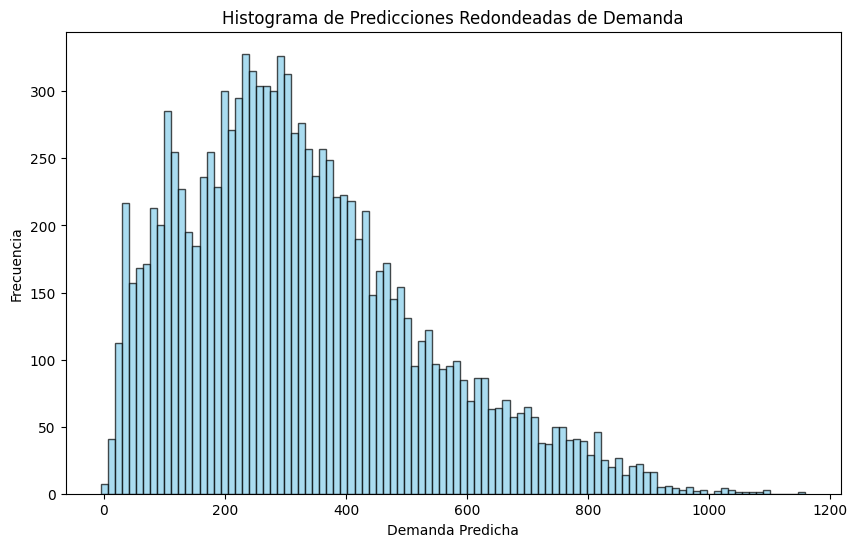

In [49]:
# Asume que predicciones_redondeadas es un array con tus datos de predicción redondeada
plt.figure(figsize=(10, 6))
plt.hist(predicciones_redondeadas, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Demanda Predicha')
plt.ylabel('Frecuencia')
plt.title('Histograma de Predicciones Redondeadas de Demanda')
plt.show()